# Notebook 05: SLM Evaluation (Finetuned)

## Ziel dieses Notebooks

1. **Finetuned SLMs laden** - Die trainierten 3B Modelle
2. **Test-Evaluation** - Auf dem Test-Set evaluieren
3. **Metriken berechnen** - Accuracy, F1, Precision, Recall
4. **Mit LLM-Baseline vergleichen** - Zeigt der Finetuning-Effekt?

---

## Theoretischer Hintergrund

### Warum SLM Evaluation?

- **Hypothese**: Spezialisierte kleine Modelle können große generische Modelle schlagen
- **Verifikation**: Trainingseffekt auf ungesehenen Daten (Test-Set)
- **Vergleich**: Sind 3B+LoRA besser als 8B Zero-Shot?

### Erwartete Ergebnisse

Typischerweise sollten finetuned Modelle:
- Höhere Exact Match Accuracy haben
- Bessere ICD-10 Formatierung zeigen
- Konsistentere Outputs generieren

### Evaluation-Strategie

```
Finetuned SLM
      ↓
Test-Dialoge als Input
      ↓
Generiere ICD-10 Codes
      ↓
Vergleiche mit Ground Truth
      ↓
Berechne Metriken
```

---

In [1]:
# ============================================================
# SETUP: Imports und Umgebung
# ============================================================

import os
import gc
import re
import json
import time
import warnings
from pathlib import Path
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, Union
from datetime import datetime

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from sklearn.metrics import precision_recall_fscore_support

print("Imports erfolgreich!")
print(f"   PyTorch: {torch.__version__}")
print(f"   CUDA verfügbar: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Imports erfolgreich!
   PyTorch: 2.10.0+cu128
   CUDA verfügbar: True
   GPU: NVIDIA GeForce RTX 5090
   VRAM: 33.6 GB


In [2]:
# ============================================================
# KONFIGURATION (Standalone)
# ============================================================

@dataclass
class PathConfig:
    project_root: Path = field(default_factory=lambda: Path.cwd().parent)
    data_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data")
    cache_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data" / "cache")
    processed_data_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data" / "processed")
    models_dir: Path = field(default_factory=lambda: Path.cwd().parent / "models")
    finetuned_models_dir: Path = field(default_factory=lambda: Path.cwd().parent / "models" / "finetuned")
    outputs_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs")
    plots_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "plots")
    reports_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "reports")
    
    def create_directories(self):
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if isinstance(attr, Path) and not attr_name.startswith('_'):
                attr.mkdir(parents=True, exist_ok=True)

@dataclass
class DataConfig:
    dataset_name: str = "Ahmad0067/MedSynth"
    dataset_split_seed: int = 42
    max_sequence_length: int = 512

@dataclass  
class ModelConfig:
    """SLM Modelle (finetuned)."""
    slm_models: List[Dict] = field(default_factory=lambda: [
        {
            "name": "meta-llama/Llama-3.2-3B-Instruct",
            "size": "3B",
            "finetuned_path": "Llama-3.2-3B-Instruct",  # Relativ zu finetuned_models_dir
        },
        {
            "name": "Qwen/Qwen2.5-3B-Instruct",
            "size": "3B",
            "finetuned_path": "Qwen2.5-3B-Instruct",
        },
    ])

@dataclass
class EvaluationConfig:
    eval_batch_size: int = 64
    max_new_tokens: int = 50
    temperature: float = 0.1
    do_sample: bool = False

@dataclass
class Config:
    paths: PathConfig = field(default_factory=PathConfig)
    data: DataConfig = field(default_factory=DataConfig)
    model: ModelConfig = field(default_factory=ModelConfig)
    evaluation: EvaluationConfig = field(default_factory=EvaluationConfig)
    
    def setup(self):
        self.paths.create_directories()
        if torch.cuda.is_available():
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True

config = Config()
config.setup()

print("Konfiguration geladen!")
print(f"   SLM Modelle: {len(config.model.slm_models)}")
for m in config.model.slm_models:
    print(f"      - {m['name']} ({m['size']})")

Konfiguration geladen!
   SLM Modelle: 2
      - meta-llama/Llama-3.2-3B-Instruct (3B)
      - Qwen/Qwen2.5-3B-Instruct (3B)


## 1. Utility-Funktionen

In [3]:
# ============================================================
# UTILITY-FUNKTIONEN (Standalone)
# ============================================================

def get_device() -> str:
    """Bestimmt das beste verfügbare Device."""
    if torch.cuda.is_available():
        return "cuda"
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return "mps"
    return "cpu"

def aggressive_memory_cleanup():
    """Aggressive Memory-Cleanup."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        torch.cuda.ipc_collect()

def log_gpu_memory(prefix: str = ""):
    """Loggt GPU Memory Status."""
    if not torch.cuda.is_available():
        return
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    msg = f"GPU: {allocated:.2f}GB alloc, {reserved:.2f}GB reserved"
    if prefix:
        msg = f"{prefix} - {msg}"
    print(msg)

def extract_icd_code(generated_text: str) -> str:
    """Extrahiert ICD-10 Code aus generiertem Text."""
    text = generated_text.strip()
    
    pattern = r'\b[A-Z]\d{2}(?:\.\d{1,2})?\b'
    matches = re.findall(pattern, text.upper())
    
    if matches:
        return matches[0]
    
    lines = text.split('\n')
    if lines:
        first_line = lines[0].strip()
        matches = re.findall(pattern, first_line.upper())
        if matches:
            return matches[0]
        return first_line[:10]
    
    return text[:10]

print(f"Device: {get_device()}")

Device: cuda


## 2. SLM Model Wrapper

In [4]:
# ============================================================
# SLM MODEL WRAPPER (Standalone)
# ============================================================

class SLMModel:
    """
    Wrapper für finetuned Small Language Models.
    
    Unterstützt:
    - LoRA Adapter laden
    - Merged Modelle laden
    - Batch Prediction
    """
    
    def __init__(
        self,
        base_model_name: str,
        finetuned_path: Path,
        device: str = "cuda",
        use_merged: bool = True,
    ):
        """
        Args:
            base_model_name: HuggingFace Modell-ID
            finetuned_path: Pfad zum finetuned Modell
            device: Target device
            use_merged: Merged Modell verwenden (einfacher)
        """
        self.base_model_name = base_model_name
        self.finetuned_path = Path(finetuned_path)
        self.device = device
        self.use_merged = use_merged
        self.model = None
        self.tokenizer = None
        self.is_loaded = False
    
    def load(self):
        """Lädt finetuned Modell."""
        print(f"📥 Lade SLM: {self.finetuned_path.name}")
        
        if self.use_merged:
            # Merged Modell direkt laden
            merged_path = self.finetuned_path / "merged"
            if merged_path.exists():
                model_path = merged_path
            else:
                model_path = self.finetuned_path
            
            self.tokenizer = AutoTokenizer.from_pretrained(model_path)
            self.model = AutoModelForCausalLM.from_pretrained(
                model_path,
                torch_dtype=torch.bfloat16,
                device_map="auto",
            )
        else:
            # LoRA Adapter laden
            self.tokenizer = AutoTokenizer.from_pretrained(self.base_model_name)
            base_model = AutoModelForCausalLM.from_pretrained(
                self.base_model_name,
                torch_dtype=torch.bfloat16,
                device_map="auto",
            )
            self.model = PeftModel.from_pretrained(base_model, self.finetuned_path)
        
        self.tokenizer.padding_side = "left"
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.model.eval()
        self.is_loaded = True
        
        print(f"Modell geladen!")
        log_gpu_memory("Nach Laden")
    
    def predict(
        self,
        input_text: Union[str, List[str]],
        max_new_tokens: int = 50,
        temperature: float = 0.1,
        do_sample: bool = False,
        **kwargs
    ) -> Union[str, List[str]]:
        """Generiert Prediction(s)."""
        if not self.is_loaded:
            raise ValueError("Modell nicht geladen!")
        
        is_single = isinstance(input_text, str)
        texts = [input_text] if is_single else input_text
        
        inputs = self.tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=2048
        ).to(self.model.device)
        
        gen_kwargs = {
            "max_new_tokens": max_new_tokens,
            "do_sample": do_sample,
            "pad_token_id": self.tokenizer.pad_token_id,
            "eos_token_id": self.tokenizer.eos_token_id,
        }
        
        if do_sample:
            gen_kwargs["temperature"] = temperature
        
        with torch.no_grad():
            outputs = self.model.generate(**inputs, **gen_kwargs)
        
        input_length = inputs["input_ids"].shape[1]
        generated_tokens = outputs[:, input_length:]
        
        decoded = self.tokenizer.batch_decode(
            generated_tokens, 
            skip_special_tokens=True
        )
        
        return decoded[0] if is_single else decoded
    
    def predict_batch(
        self,
        input_texts: List[str],
        batch_size: int = 8,
        show_progress: bool = True,
        **kwargs
    ) -> List[str]:
        """Batched Prediction."""
        if not self.is_loaded:
            raise ValueError("Modell nicht geladen!")
        
        all_predictions = []
        n_batches = (len(input_texts) + batch_size - 1) // batch_size
        
        iterator = range(0, len(input_texts), batch_size)
        if show_progress:
            iterator = tqdm(iterator, total=n_batches, desc="Generiere Predictions")
        
        for i in iterator:
            batch = input_texts[i:i + batch_size]
            predictions = self.predict(batch, **kwargs)
            if isinstance(predictions, str):
                predictions = [predictions]
            all_predictions.extend(predictions)
        
        return all_predictions
    
    def unload(self):
        """Entlädt Modell."""
        if self.model is not None:
            del self.model
            self.model = None
        if self.tokenizer is not None:
            del self.tokenizer
            self.tokenizer = None
        
        aggressive_memory_cleanup()
        self.is_loaded = False
        print(f"Modell entladen")
        log_gpu_memory("Nach Entladen")

print("SLMModel-Klasse definiert!")

SLMModel-Klasse definiert!


## 3. Medical Dialog Processor und Evaluator

In [5]:
# ============================================================
# PROCESSOR UND EVALUATOR (Standalone)
# ============================================================

class MedicalDialogProcessor:
    """Formatiert Dialoge für Inference."""
    
    SYSTEM_PROMPT = """You are a medical assistance system that supports doctors in making diagnoses. 
Your task is to suggest the appropriate ICD-10 diagnosis code based on a doctor-patient dialogue.
Respond only with the ICD-10 code, without further explanation."""
    
    def __init__(self, tokenizer=None):
        self.tokenizer = tokenizer
    
    def format_dialog_for_inference(self, conversation: str) -> str:
        """Formatiert Dialog für Inference."""
        user_prompt = f"""Analyze the following doctor-patient dialogue and determine the appropriate ICD-10 code:

{conversation}

ICD-10 Code:"""
        
        if self.tokenizer and hasattr(self.tokenizer, 'chat_template') and self.tokenizer.chat_template:
            messages = [
                {"role": "system", "content": self.SYSTEM_PROMPT},
                {"role": "user", "content": user_prompt},
            ]
            try:
                return self.tokenizer.apply_chat_template(
                    messages, tokenize=False, add_generation_prompt=True
                )
            except:
                pass
        
        return f"System: {self.SYSTEM_PROMPT}\n\nUser: {user_prompt}\n\nAssistant:"


class MedicalDiagnosisEvaluator:
    """Evaluator für ICD-10 Code Predictions."""
    
    def __init__(self):
        self.predictions = []
        self.references = []
    
    def add_batch(self, predictions: List[str], references: List[str]):
        self.predictions.extend(predictions)
        self.references.extend(references)
    
    def compute_exact_match_accuracy(self) -> float:
        if not self.predictions:
            return 0.0
        matches = sum(
            1 for p, r in zip(self.predictions, self.references)
            if p.strip().upper() == r.strip().upper()
        )
        return matches / len(self.predictions)
    
    def compute_prefix_match_accuracy(self, prefix_length: int = 3) -> float:
        if not self.predictions:
            return 0.0
        matches = sum(
            1 for p, r in zip(self.predictions, self.references)
            if p[:prefix_length].upper() == r[:prefix_length].upper()
        )
        return matches / len(self.predictions)
    
    def compute_classification_metrics(self) -> Dict:
        if not self.predictions:
            return {}
        
        precision, recall, f1, _ = precision_recall_fscore_support(
            self.references, self.predictions, 
            average="weighted", zero_division=0
        )
        
        return {
            "precision": float(precision),
            "recall": float(recall), 
            "f1": float(f1)
        }
    
    def compute_all_metrics(self) -> Dict:
        metrics = {
            "n_samples": len(self.predictions),
            "exact_match_accuracy": self.compute_exact_match_accuracy(),
            "prefix_match_3": self.compute_prefix_match_accuracy(3),
            "prefix_match_1": self.compute_prefix_match_accuracy(1),
        }
        metrics.update(self.compute_classification_metrics())
        return metrics
    
    def reset(self):
        self.predictions = []
        self.references = []

print("Processor und Evaluator definiert!")

Processor und Evaluator definiert!


## 4. Test-Daten laden

In [6]:
# ============================================================
# TEST-DATEN LADEN
# ============================================================

test_path = config.paths.processed_data_dir / "test_raw"

if test_path.exists():
    print(f"Lade gespeicherte Test-Daten: {test_path}")
    test_data = load_from_disk(str(test_path))
else:
    print(f"Lade Dataset von HuggingFace...")
    dataset = load_dataset(config.data.dataset_name, cache_dir=str(config.paths.cache_dir))
    
    if isinstance(dataset, DatasetDict):
        dataset = dataset["train"] if "train" in dataset else dataset[list(dataset.keys())[0]]
    
    train_test = dataset.train_test_split(test_size=0.30, seed=config.data.dataset_split_seed)
    val_test = train_test["test"].train_test_split(test_size=0.50, seed=config.data.dataset_split_seed)
    test_data = val_test["test"]

# Felder identifizieren
dialog_field = 'Dialogue' if 'Dialogue' in test_data.features else 'dialogue'
icd_field = 'ICD10' if 'ICD10' in test_data.features else 'icd10'

print(f"Test-Daten geladen: {len(test_data):,} Samples")

Lade gespeicherte Test-Daten: /home/bmw/src/simon/finetuning/data/processed/test_raw
Test-Daten geladen: 1,024 Samples


## 5. SLM Evaluation durchführen

In [7]:
# ============================================================
# EVALUATION-FUNKTION
# ============================================================

def evaluate_slm(
    model_config: Dict,
    test_data: Dataset,
    config: Config,
    max_samples: Optional[int] = None
) -> Dict:
    """Evaluiert ein finetuned SLM."""
    model_name = model_config["name"]
    model_short = model_name.split("/")[-1]
    finetuned_path = config.paths.finetuned_models_dir / model_config["finetuned_path"]
    
    print(f"\n{'='*60}")
    print(f"Evaluiere: {model_short} (Finetuned)")
    print(f"{'='*60}")
    
    if not finetuned_path.exists():
        print(f"Finetuned Modell nicht gefunden: {finetuned_path}")
        return None
    
    # Modell laden
    slm = SLMModel(
        base_model_name=model_name,
        finetuned_path=finetuned_path,
        device=get_device(),
        use_merged=True,
    )
    slm.load()
    
    # Processor erstellen
    processor = MedicalDialogProcessor(tokenizer=slm.tokenizer)
    
    # Daten vorbereiten
    if max_samples:
        eval_data = test_data.select(range(min(max_samples, len(test_data))))
    else:
        eval_data = test_data
    
    conversations = [sample[dialog_field] for sample in eval_data]
    references = [sample[icd_field] for sample in eval_data]
    
    prompts = [processor.format_dialog_for_inference(conv) for conv in conversations]
    
    print(f"   Samples: {len(prompts)}")
    
    # Predictions generieren
    start_time = time.time()
    
    predictions_raw = slm.predict_batch(
        prompts,
        batch_size=config.evaluation.eval_batch_size,
        max_new_tokens=config.evaluation.max_new_tokens,
        temperature=config.evaluation.temperature,
        do_sample=config.evaluation.do_sample,
    )
    
    eval_time = time.time() - start_time
    
    # ICD-Codes extrahieren
    predictions = [extract_icd_code(pred) for pred in predictions_raw]
    
    # Metriken berechnen
    evaluator = MedicalDiagnosisEvaluator()
    evaluator.add_batch(predictions, references)
    metrics = evaluator.compute_all_metrics()
    
    # Zusätzliche Infos
    metrics["model_name"] = model_name
    metrics["model_size"] = model_config["size"]
    metrics["model_type"] = "SLM"
    metrics["training"] = "LoRA Finetuned"
    metrics["eval_time_seconds"] = eval_time
    metrics["samples_per_second"] = len(prompts) / eval_time
    
    print(f"\nErgebnisse:")
    print(f"   Exact Match Accuracy: {metrics['exact_match_accuracy']:.4f} ({metrics['exact_match_accuracy']*100:.2f}%)")
    print(f"   Prefix Match (3): {metrics['prefix_match_3']:.4f}")
    print(f"   F1-Score: {metrics.get('f1', 0):.4f}")
    print(f"   Zeit: {eval_time:.1f}s ({metrics['samples_per_second']:.1f} samples/s)")
    
    # Cleanup
    slm.unload()
    
    return metrics, predictions, references

print("Evaluation-Funktion definiert!")

Evaluation-Funktion definiert!


In [8]:
# ============================================================
# SLMs EVALUIEREN
# ============================================================

slm_results = {}

MAX_SAMPLES = None  # Setze auf 100 für schnellen Test

for slm_config in config.model.slm_models:
    result = evaluate_slm(slm_config, test_data, config, max_samples=MAX_SAMPLES)
    
    if result is not None:
        metrics, predictions, references = result
        model_key = f"SLM_{slm_config['name'].split('/')[-1]}_finetuned"
        slm_results[model_key] = metrics


Evaluiere: Llama-3.2-3B-Instruct (Finetuned)
📥 Lade SLM: Llama-3.2-3B-Instruct


`torch_dtype` is deprecated! Use `dtype` instead!
Loading weights: 100%|██████████| 254/254 [00:00<00:00, 359.50it/s, Materializing param=model.norm.weight]                              


Modell geladen!
Nach Laden - GPU: 6.43GB alloc, 6.44GB reserved
   Samples: 1024


Generiere Predictions: 100%|██████████| 16/16 [02:14<00:00,  8.39s/it]



Ergebnisse:
   Exact Match Accuracy: 0.0000 (0.00%)
   Prefix Match (3): 0.0039
   F1-Score: 0.0000
   Zeit: 134.2s (7.6 samples/s)
Modell entladen
Nach Entladen - GPU: 0.01GB alloc, 0.04GB reserved

Evaluiere: Qwen2.5-3B-Instruct (Finetuned)
📥 Lade SLM: Qwen2.5-3B-Instruct


Loading weights: 100%|██████████| 434/434 [00:00<00:00, 635.62it/s, Materializing param=model.norm.weight]                              


Modell geladen!
Nach Laden - GPU: 6.18GB alloc, 6.26GB reserved
   Samples: 1024


Generiere Predictions: 100%|██████████| 16/16 [01:07<00:00,  4.25s/it]



Ergebnisse:
   Exact Match Accuracy: 0.0020 (0.20%)
   Prefix Match (3): 0.0469
   F1-Score: 0.0007
   Zeit: 68.0s (15.1 samples/s)
Modell entladen
Nach Entladen - GPU: 0.01GB alloc, 0.05GB reserved


## 6. Mit LLM-Baseline vergleichen

In [ ]:
# ============================================================
# LLM BASELINE LADEN
# ============================================================

llm_results_path = config.paths.reports_dir / "llm_baseline_results.json"

if llm_results_path.exists():
    with open(llm_results_path, 'r') as f:
        llm_results = json.load(f)
    print(f"LLM Baseline geladen: {len(llm_results)} Modelle")
else:
    print("LLM Baseline nicht gefunden. Bitte Notebook 03 zuerst ausführen.")
    llm_results = {}

# Alle Ergebnisse kombinieren
all_results = {}
all_results.update(llm_results)
all_results.update(slm_results)

print(f"\nGesamt: {len(all_results)} Modelle evaluiert")

LLM Baseline geladen: 2 Modelle

📊 Gesamt: 4 Modelle evaluiert


In [10]:
# ============================================================
# VERGLEICHSTABELLE
# ============================================================

print("Vergleich: LLM vs. Finetuned SLM")
print("=" * 80)

results_df = pd.DataFrame([
    {
        "Modell": key.replace("LLM_", "").replace("SLM_", "").replace("_untrained", "").replace("_finetuned", ""),
        "Typ": "LLM" if key.startswith("LLM") else "SLM",
        "Training": metrics.get("training", ""),
        "Größe": metrics.get("model_size", ""),
        "Accuracy": metrics["exact_match_accuracy"],
        "Prefix-3": metrics.get("prefix_match_3", 0),
        "F1": metrics.get("f1", 0),
    }
    for key, metrics in all_results.items()
])

# Nach Accuracy sortieren
results_df = results_df.sort_values("Accuracy", ascending=False)
print(results_df.to_string(index=False))

# Bestes Modell
best_overall = max(all_results.items(), key=lambda x: x[1]["exact_match_accuracy"])
print(f"\nBestes Modell insgesamt: {best_overall[0]}")
print(f"   Accuracy: {best_overall[1]['exact_match_accuracy']:.2%}")

Vergleich: LLM vs. Finetuned SLM
                    Modell Typ       Training Größe  Accuracy  Prefix-3       F1
Meta-Llama-3.1-8B-Instruct LLM      Zero-Shot    8B  0.034180  0.246094 0.000000
  Mistral-7B-Instruct-v0.3 LLM      Zero-Shot    7B  0.020508  0.214844 0.000000
       Qwen2.5-3B-Instruct SLM LoRA Finetuned    3B  0.001953  0.046875 0.000716
     Llama-3.2-3B-Instruct SLM LoRA Finetuned    3B  0.000000  0.003906 0.000000

Bestes Modell insgesamt: LLM_Meta-Llama-3.1-8B-Instruct_untrained
   Accuracy: 3.42%


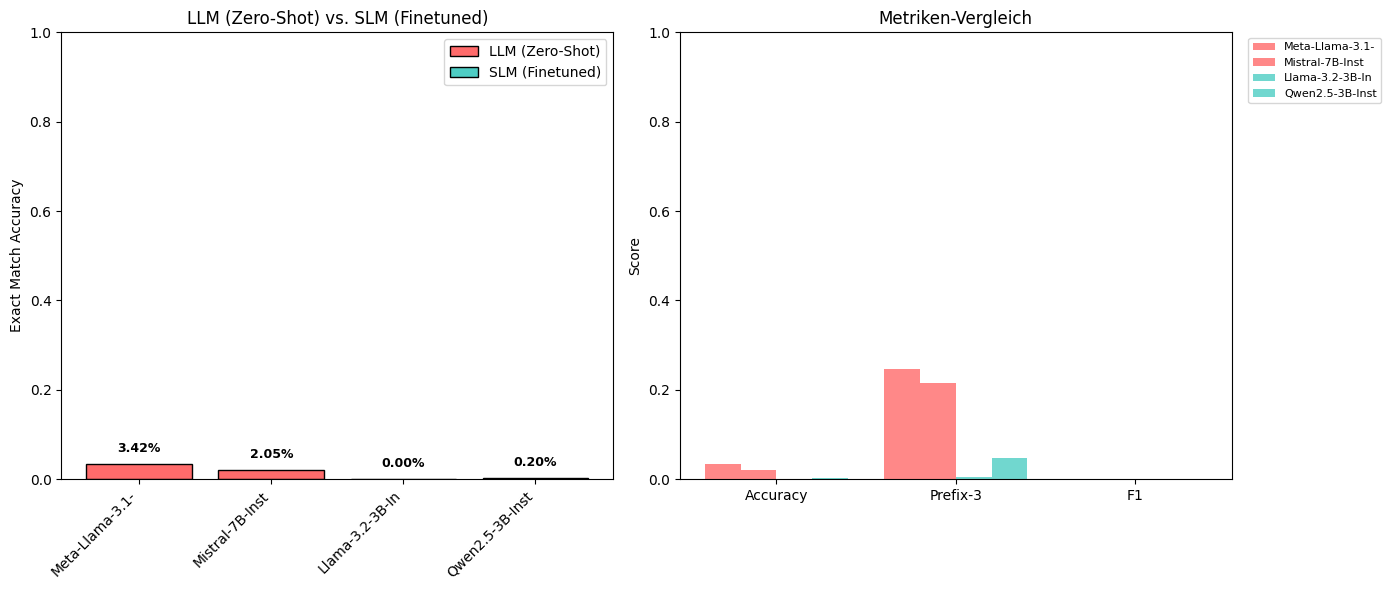

💾 Plot gespeichert!


In [11]:
# ============================================================
# VISUALISIERUNG
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy-Vergleich
models = list(all_results.keys())
accuracies = [all_results[m]["exact_match_accuracy"] for m in models]
short_names = [m.replace("LLM_", "").replace("SLM_", "").replace("_untrained", "").replace("_finetuned", "")[:15] for m in models]
types = ["LLM" if m.startswith("LLM") else "SLM" for m in models]
colors = ["#FF6B6B" if t == "LLM" else "#4ECDC4" for t in types]

bars = axes[0].bar(range(len(models)), accuracies, color=colors, edgecolor='black')
axes[0].set_xticks(range(len(models)))
axes[0].set_xticklabels(short_names, rotation=45, ha='right')
axes[0].set_ylabel('Exact Match Accuracy')
axes[0].set_title('LLM (Zero-Shot) vs. SLM (Finetuned)')
axes[0].set_ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{acc:.2%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Legende
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', edgecolor='black', label='LLM (Zero-Shot)'),
    Patch(facecolor='#4ECDC4', edgecolor='black', label='SLM (Finetuned)'),
]
axes[0].legend(handles=legend_elements, loc='upper right')

# Metriken-Vergleich für alle
metrics_names = ['Accuracy', 'Prefix-3', 'F1']
x = np.arange(len(metrics_names))
width = 0.8 / len(models)

for i, model in enumerate(models):
    metrics = all_results[model]
    values = [
        metrics["exact_match_accuracy"],
        metrics.get("prefix_match_3", 0),
        metrics.get("f1", 0),
    ]
    color = "#FF6B6B" if model.startswith("LLM") else "#4ECDC4"
    axes[1].bar(x + i*width, values, width, label=short_names[i], alpha=0.8, color=color)

axes[1].set_xticks(x + width * (len(models)-1) / 2)
axes[1].set_xticklabels(metrics_names)
axes[1].set_ylabel('Score')
axes[1].set_title('Metriken-Vergleich')
axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(config.paths.plots_dir / 'slm_vs_llm_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Plot gespeichert!")

## 7. Ergebnisse speichern

In [12]:
# ============================================================
# ERGEBNISSE SPEICHERN
# ============================================================

# SLM Ergebnisse
slm_results_path = config.paths.reports_dir / "slm_finetuned_results.json"
with open(slm_results_path, 'w') as f:
    json.dump(slm_results, f, indent=2, default=str)

print(f"💾 SLM Ergebnisse gespeichert: {slm_results_path}")

# Kombinierte Ergebnisse
combined_path = config.paths.reports_dir / "combined_results.json"
with open(combined_path, 'w') as f:
    json.dump(all_results, f, indent=2, default=str)

print(f"💾 Kombinierte Ergebnisse gespeichert: {combined_path}")

# DataFrame als CSV
csv_path = config.paths.reports_dir / "results_comparison.csv"
results_df.to_csv(csv_path, index=False)
print(f"💾 CSV gespeichert: {csv_path}")

💾 SLM Ergebnisse gespeichert: /home/bmw/src/simon/finetuning/outputs/reports/slm_finetuned_results.json
💾 Kombinierte Ergebnisse gespeichert: /home/bmw/src/simon/finetuning/outputs/reports/combined_results.json
💾 CSV gespeichert: /home/bmw/src/simon/finetuning/outputs/reports/results_comparison.csv


In [13]:
# ============================================================
# FINALE ZUSAMMENFASSUNG
# ============================================================

print("=" * 60)
print("📊 ZUSAMMENFASSUNG: SLM Evaluation")
print("=" * 60)
print(f"""
✅ Evaluation abgeschlossen!

📊 Alle evaluierten Modelle:
""")

for model, metrics in sorted(all_results.items(), key=lambda x: -x[1]["exact_match_accuracy"]):
    typ = "LLM" if model.startswith("LLM") else "SLM"
    short = model.replace("LLM_", "").replace("SLM_", "").replace("_untrained", "").replace("_finetuned", "")
    training = metrics.get("training", "")
    print(f"   • [{typ}] {short} ({training}):")
    print(f"     Accuracy: {metrics['exact_match_accuracy']:.2%}, F1: {metrics.get('f1', 0):.4f}")

print(f"""
🏆 Bestes Modell: {best_overall[0].replace('LLM_', '').replace('SLM_', '')}
   Accuracy: {best_overall[1]['exact_match_accuracy']:.2%}

💡 Interpretation:
""")

# Analyse
if slm_results and llm_results:
    best_slm = max(slm_results.items(), key=lambda x: x[1]["exact_match_accuracy"])
    best_llm = max(llm_results.items(), key=lambda x: x[1]["exact_match_accuracy"])
    
    slm_acc = best_slm[1]["exact_match_accuracy"]
    llm_acc = best_llm[1]["exact_match_accuracy"]
    
    if slm_acc > llm_acc:
        improvement = (slm_acc - llm_acc) / llm_acc * 100
        print(f"   ✅ Finetuned SLM schlägt LLM Baseline um {improvement:.1f}%!")
        print(f"   → Spezialisierung > Größe für diese Aufgabe")
    else:
        print(f"   ⚠️ LLM Baseline ist noch besser")
        print(f"   → Mehr Training oder bessere Hyperparameter nötig")

print(f"""
💾 Gespeicherte Dateien:
   • {slm_results_path}
   • {combined_path}
   • {csv_path}
   • {config.paths.plots_dir / 'slm_vs_llm_comparison.png'}

➡️ Nächster Schritt: Notebook 06 - Ergebnisanalyse
""")

📊 ZUSAMMENFASSUNG: SLM Evaluation

✅ Evaluation abgeschlossen!

📊 Alle evaluierten Modelle:

   • [LLM] Meta-Llama-3.1-8B-Instruct (Zero-Shot):
     Accuracy: 3.42%, F1: 0.0000
   • [LLM] Mistral-7B-Instruct-v0.3 (Zero-Shot):
     Accuracy: 2.05%, F1: 0.0000
   • [SLM] Qwen2.5-3B-Instruct (LoRA Finetuned):
     Accuracy: 0.20%, F1: 0.0007
   • [SLM] Llama-3.2-3B-Instruct (LoRA Finetuned):
     Accuracy: 0.00%, F1: 0.0000

🏆 Bestes Modell: Meta-Llama-3.1-8B-Instruct_untrained
   Accuracy: 3.42%

💡 Interpretation:

   ⚠️ LLM Baseline ist noch besser
   → Mehr Training oder bessere Hyperparameter nötig

💾 Gespeicherte Dateien:
   • /home/bmw/src/simon/finetuning/outputs/reports/slm_finetuned_results.json
   • /home/bmw/src/simon/finetuning/outputs/reports/combined_results.json
   • /home/bmw/src/simon/finetuning/outputs/reports/results_comparison.csv
   • /home/bmw/src/simon/finetuning/outputs/plots/slm_vs_llm_comparison.png

➡️ Nächster Schritt: Notebook 06 - Ergebnisanalyse



---

**✅ Notebook 05 abgeschlossen!**

Fahren Sie mit **Notebook 06: Ergebnisanalyse und Visualisierung** fort.